# Test runs
Below follows some test runs of my implementations on basic problems.

In [181]:
from utils import *
import ols, ridge, logistic, neural
from FeedForwardNeuralNetwork import Layer, FFNN
from StochasticGradientDescent import SGD

### ```SGD``` class on basic first-degree polynomial line-fitting problem

In [2]:
n = 100
np.random.seed(0)
x = np.random.rand(n,1)
y = 4 + 2*x + .05*np.random.rand(n,1)
X = np.c_[np.ones(n), x]

In [3]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
print('ols-inversion:\n', beta)

ols-inversion:
 [[4.027904  ]
 [1.99682755]]


In [4]:
from StochasticGradientDescent import SGD

sgd = SGD(epochs=50, batches=5, eta0=.01, learning_schedule='constant', regression='linear')
beta = sgd.run(X, y)
print('ols-sgd:\n', beta)

sgd = SGD(epochs=1000, batches=10, eta0=.7, learning_schedule='constant', regression='linear')
beta = sgd.run(X, y, lmd=.1)
print('ridge-sgd:\n', beta)

ols-sgd:
 [[4.0077004 ]
 [2.01803235]]
ridge-sgd:
 [[3.79292034]
 [1.9169758 ]]


### `SGD` class together with implementations of OLS and Ridge in `ols.py` and `ridge.py` 

In [5]:
import ols, ridge
from utils import *

n = 100
x, y = randmesh(sn=n)
z = 1. + 2.*x + 3.*y + 4.*x*x + 5*x*y + 6*y*y + .03*np.random.rand(n,1)
X = make_design_matrix(x, y, pn=2)

In [6]:
# Direct inversion
beta = np.linalg.inv(X.T @ X) @ X.T @ z
print('ols-inversion:\n', beta)

ols-inversion:
 [[1.02429934]
 [1.98277384]
 [2.97928365]
 [4.00860255]
 [5.01623802]
 [6.00975532]]


In [7]:
# Regular OLS
sgd = SGD(epochs=50, batches=40, learning_schedule='constant', eta0=.5, regression='linear')
df = ols.run_ols_kfold(X, z, sgd, k=5, polynomial_orders=[2])
print('ols-sgd:\n', sgd.beta)
df

ols-sgd:
 [[1.07049348]
 [2.10085946]
 [2.90572522]
 [3.96732253]
 [4.93328259]
 [6.12359383]]


,pol_order,train_mse,test_mse
2,2.0,0.002434,0.002483


In [8]:
# Ridge
sgd = SGD(epochs=100, batches=40, learning_schedule='invscaling', eta0=.5, regression='linear')
ridge.run_ridge_kfold(X, z, sgd, k=5, polynomial_orders=[2], lambdas=[0.003594])
print('ridge-sgd:\n', sgd.beta)
df = ridge.run_ridge_kfold(X, z, sgd, k=5, polynomial_orders=[2], lambdas=np.logspace(-3,-2,10))
df

ridge-sgd:
 [[8.43104528]
 [0.47606812]
 [0.64298641]
 [1.24295542]
 [1.0490371 ]
 [1.9085351 ]]


,lambda,train_mse_2,test_mse_2
0,0.001000,0.003379,0.004296
1,0.001292,0.003106,0.003967
2,0.001668,0.002809,0.003607
3,0.002154,0.002515,0.003240
4,0.002783,0.002271,0.002917
5,0.003594,0.002161,0.002725
6,0.004642,0.002320,0.002807
7,0.005995,0.002960,0.003382
8,0.007743,0.004397,0.004777
9,0.010000,0.007102,0.007470


### Feed-Forwards Neural Network (`FFNN` class )
First a simple regression on a linear function; then the Franke function; then `skl` MNIST dataset and `skl` Wisconsin breast cancer dataset classification

#### FFNN Linear function fit

In [19]:
n = 100
np.random.seed(0)
x = np.random.rand(n,1)
y = 4 + 2*x + .03*np.random.rand(n,1)
X = np.c_[np.ones(n), x]
y = y / y.max()
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, train_size=.5)

r2:   0.9754002255116354 0.9835355886960825
mse:  0.0002473581924662477 0.00013944887835073405


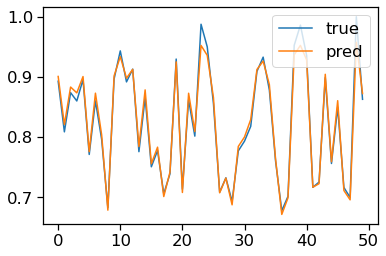

In [20]:
ffnn = FFNN(2)
ffnn.add_layer(2)
ffnn.add_layer(1)
ffnn.train(X_train, y_train, epochs=500, batches=10, eta0=.5)
out = ffnn.predict(X_train)
r2_train = r2(y_train, out)
mse_train = mse(y_train, out)
out = ffnn.predict(X_test)
r2_test = r2(y_test, out)
mse_test = mse(y_test, out)
print("r2:  ", r2_train, r2_test)
print("mse: ", mse_train, mse_test)
plt.plot(list(range(y_test.shape[0])), y_test, label='true')
plt.plot(list(range(y_test.shape[0])), out, label='pred')
plt.legend(loc='upper right')
plt.show()

#### FFNN Franke function fit

In [21]:
n = 250
x, y = randmesh(sn=n, random_state=1)
z,_,_ = franke_sampler(x, y, var_eps=.03)
X = make_design_matrix(x, y, pn=10)
z = z + np.abs(z.min())
z = z/z.max()
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, z, train_size=.7)
X_train, X_test = scale(X_train, X_test)

r2:   0.5602221420847766 0.5262302751465415
mse:  0.014685945152092619 0.018341459782309135


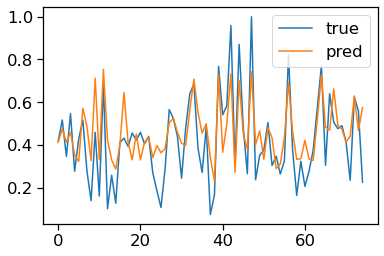

In [22]:
n, p = X_train.shape
ffnn = FFNN(p)
ffnn.add_layer(p)
ffnn.add_layer(1)

ffnn.train(X_train, y_train, epochs=250, batches=50, learning_schedule='constant', eta0=8, lmd=.0001)
out = ffnn.predict(X_train)
r2_train = r2(y_train, out)
mse_train = mse(y_train, out)
out = ffnn.predict(X_test)
r2_test = r2(y_test, out)
mse_test = mse(y_test, out)
print("r2:  ", r2_train, r2_test)
print("mse: ", mse_train, mse_test)
plt.plot(list(range(y_test.shape[0])), y_test, label='true')
plt.plot(list(range(y_test.shape[0])), out, label='pred')
plt.legend(loc='upper right')
plt.show()

In [23]:
n = 1000
x, y = randmesh(sn=n, random_state=1)
z,_,_ = franke_sampler(x, y, var_eps=.03)
X = make_design_matrix(x, y, pn=5)

z = z + np.abs(z.min())
z = z/z.max()
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, z, train_size=.7)
X_train, X_test = scale(X_train, X_test)

0.7195042284315081 0.6976007283207971


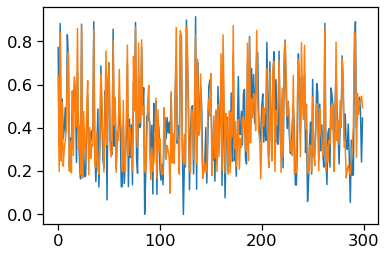

In [24]:
n, p = X_train.shape
ffnn = FFNN(p)
ffnn.add_layer(p, activation_function='sigmoid')
ffnn.add_layer(1, activation_function='sigmoid')

ffnn.train(X_train, y_train, epochs=1000, batches=50, learning_schedule='constant', eta0=.5, lmd=.0)
out = ffnn.predict(X_train)
r2_train = r2(y_train, out)

out = ffnn.predict(X_test)
r2_test = r2(y_test, out)

print(r2_train, r2_test)

plt.plot(list(range(y_test.shape[0])), y_test)
plt.plot(list(range(y_test.shape[0])), out)

#### FFNN MNIST dataset classification

X = (n_inputs, n_features) = (1797, 8, 8)


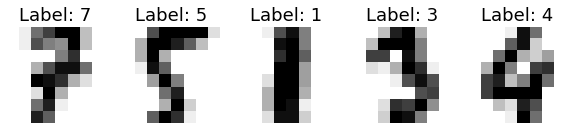

In [25]:
digits = skl.datasets.load_digits()
images = digits.images
targets = digits.target

n_images = len(images)
print("X = (n_inputs, n_features) = " + str(images.shape))

# choose some random images to display
indices = np.arange(images.shape[0])
random_indices = np.random.choice(indices, size=5)

plt.figure(figsize=(10,25))
for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

In [215]:
def plot_accuracy(accuracy_table, etas, lambdas):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(accuracy_table, annot=True, ax=ax, cmap="viridis")
    ax.set_yticklabels([fr'{np.log10(eta):.1f}' for eta in etas], fontsize=10)
    ax.set_xticklabels([fr'{np.log10(lmd):.1f}' for lmd in lambdas], fontsize=10)
    ax.set_title("Accuracy")
    ax.set_ylabel("log$_{10}\eta$")
    ax.set_xlabel("log$_{10}\lambda$")
    plt.show()

In [27]:
X = images.reshape(images.shape[0], -1)
n, p = X.shape

y = np.zeros((n,10))
for i in range(n):
    y[i, targets[i]] = 1

X_train, X_test, y_train, _, _, true = skl.model_selection.train_test_split(
    *skl.utils.resample(X, y, targets, replace=False, random_state=0), train_size=.8)

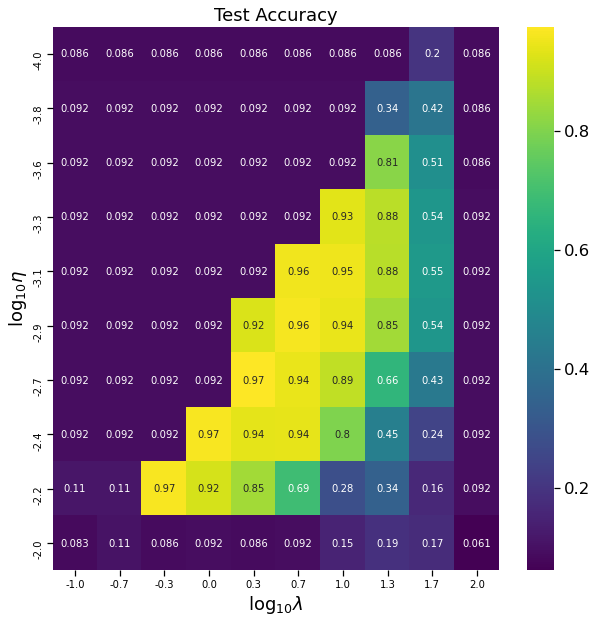

In [28]:
ffnn = FFNN(p, cost_function='cross-entropy')
ffnn.add_layer(50, activation_function='sigmoid')
ffnn.add_layer(10, activation_function='softmax')

k = 10
acc = np.zeros((k,k))
etas = np.logspace(-4,-2,k)
lambdas = np.logspace(-1,2,k)
for i, eta in enumerate(etas):
    for j, lmd in enumerate(lambdas):
        ffnn.train(X_train, y_train, epochs=100, batches=14, learning_schedule='constant', eta0=eta, lmd=lmd)
        out = ffnn.predict(X_test)
        pred = out.argmax(axis=1)
        acc[i,j] = skl.metrics.accuracy_score(true, pred)
        ffnn.reset()

plot_accuracy(acc, etas, lambdas)

#### FFNN Wisconsin breast cancer dataset classification

In [29]:
data, targets = skl.datasets.load_breast_cancer(return_X_y=True)
X = data
n, p = X.shape
y = targets.reshape(n,1)

X_train, X_test, y_train, y_test, _, true = skl.model_selection.train_test_split(
    *skl.utils.resample(X, y, tar
                        gets, replace=False, random_state=5), train_size=.7)

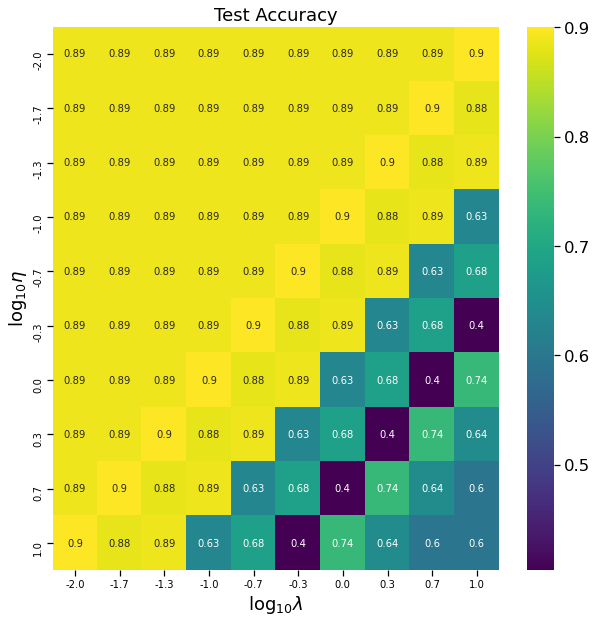

In [30]:
ffnn = FFNN(p, cost_function='cross-entropy')
#ffnn.add_layer(20, activation_function='sigmoid')
ffnn.add_layer(1, activation_function='unit-step')

k = 10
acc = np.zeros((k,k))
etas = np.logspace(-2,1,k)
lambdas = np.logspace(-2,1,k)
for i, eta in enumerate(etas):
    for j, lmd in enumerate(lambdas):
        ffnn.train(X_train, y_train, epochs=100, batches=4, learning_schedule='geron', eta0=eta, lmd=lmd)
        out = ffnn.predict(X_test)
        pred = out
        acc[i,j] = skl.metrics.accuracy_score(true, pred)
        ffnn.reset()

plot_accuracy(acc, etas, lambdas)

#### FFNN banknote forgery dataset classification

In [216]:
df = pd.read_csv('./data/data_banknote_authentication.txt', header=None)
X = df[[0,1,2,3]].to_numpy()
y = df[4].to_numpy()
n, p = X.shape
y = y.reshape(n, 1)
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(
    *skl.utils.resample(X, y, replace=False, random_state=1), train_size=.7)

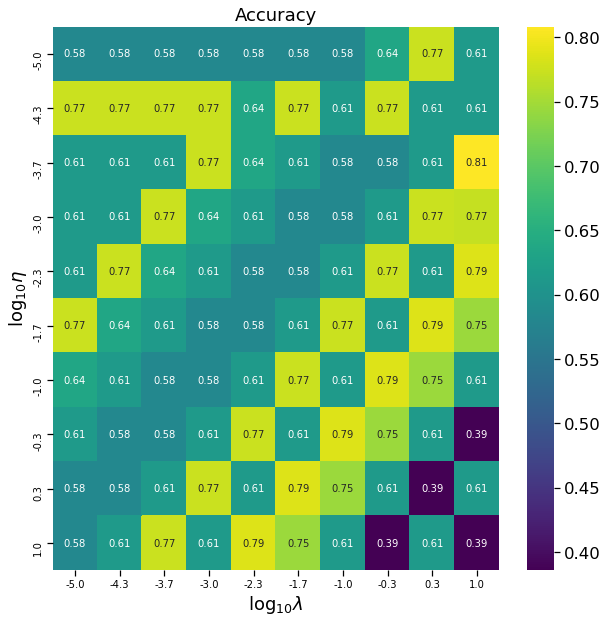

In [218]:
ffnn = FFNN(p, cost_function='cross-entropy')
ffnn.add_layer(2, activation_function='sigmoid')
ffnn.add_layer(1, activation_function='unit-step')

k = 10
acc = np.zeros((k,k))
etas = np.logspace(-5,1,k)
lambdas = np.logspace(-5,1,k)
for i, eta in enumerate(etas):
    for j, lmd in enumerate(lambdas):
        ffnn.train(X_train, y_train, epochs=100, batch_size=50, learning_schedule='geron', eta0=eta, lmd=lmd)
        out = ffnn.predict(X_test)
        pred = out
        acc[i,j] = skl.metrics.accuracy_score(y_test, pred)
        ffnn.reset()

plot_accuracy(acc, etas, lambdas)

#### Logistic regression banknote forgery dataset classification

In [33]:
df = pd.read_csv('./data/data_banknote_authentication.txt', header=None)
X = df[[0,1,2,3]].to_numpy()
t = df[4].to_numpy()
n, p = X.shape
y = onehot(t, 2)
X_train, X_test, y_train, y_test, _, true = skl.model_selection.train_test_split(
    *skl.utils.resample(X, y, t, replace=False, random_state=5), train_size=.7)

sgd = SGD(regression='logistic')
B = sgd.run(X_train, y_train)
pred = softmax(X_test @ B).argmax(axis=1)
skl.metrics.accuracy_score(true, pred)

0.9635922330097088

In [165]:
X, t = skl.datasets.load_digits(return_X_y=True)
n, p = X.shape
y = onehot(t, 10)
X_train, X_test, y_train, y_test, _, true = skl.model_selection.train_test_split(
    *skl.utils.resample(X, y, t, replace=False, random_state=4), train_size=.7)

sgd = SGD(regression='logistic', eta0=.1, classes=10)
B = sgd.run(X_train, y_train)
pred = softmax(X_test @ B).argmax(axis=1)
skl.metrics.accuracy_score(true, pred)

0.9611111111111111

In [146]:
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])

t = np.array([[0],
              [1],
              [1],
              [0]])

ffnn = FFNN(p, cost_function='cross-entropy')
ffnn.add_layer(2, activation_function='relu')
ffnn.add_layer(1, activation_function='relu')
ffnn.layers[0].biases = np.array([0,-1])
ffnn.layers[0].weights = np.array([[1,1],[1,1]])
ffnn.layers[1].weights = np.array([[1],[-2]])

ffnn.train(X, t, epochs=1, batches=1, learning_schedule='constant', eta0=.001, lmd=0)
out = ffnn.predict(X)
out

array([[0.01093005],
       [1.00278516],
       [1.00278516],
       [0.        ]])

In [179]:
X, t = skl.datasets.load_digits(return_X_y=True)
n, p = X.shape
t_onehot = onehot(t, 10)

sgd = SGD(learning_schedule='invscaling', regression='logistic', classes=10)
etas = np.logspace(-5,2,8)
lambdas = np.logspace(-5,0,6)
train, test = logistic.run_logistic_kfold(X, t, t_onehot, sgd, etas=etas, lambdas=lambdas, k=5)

/home/olav/Documents/stud/FYS-STK4155/project2/source/StochasticGradientDescent.py:29: RuntimeWarning: overflow encountered in exp
  e = np.exp(X @ beta)
/home/olav/Documents/stud/FYS-STK4155/project2/source/StochasticGradientDescent.py:30: RuntimeWarning: invalid value encountered in true_divide
  mu = e/np.sum(e, axis=1, keepdims=True)
/home/olav/Documents/stud/FYS-STK4155/project2/source/StochasticGradientDescent.py:29: RuntimeWarning: overflow encountered in exp
  e = np.exp(X @ beta)
/home/olav/Documents/stud/FYS-STK4155/project2/source/StochasticGradientDescent.py:30: RuntimeWarning: invalid value encountered in true_divide
  mu = e/np.sum(e, axis=1, keepdims=True)
/home/olav/Documents/stud/FYS-STK4155/project2/source/StochasticGradientDescent.py:29: RuntimeWarning: overflow encountered in exp
  e = np.exp(X @ beta)
/home/olav/Documents/stud/FYS-STK4155/project2/source/StochasticGradientDescent.py:30: RuntimeWarning: invalid value encountered in true_divide
  mu = e/np.sum(e, axi

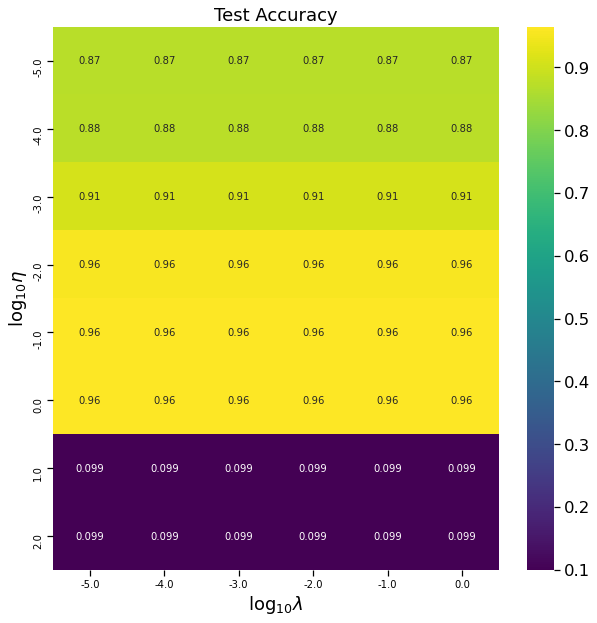

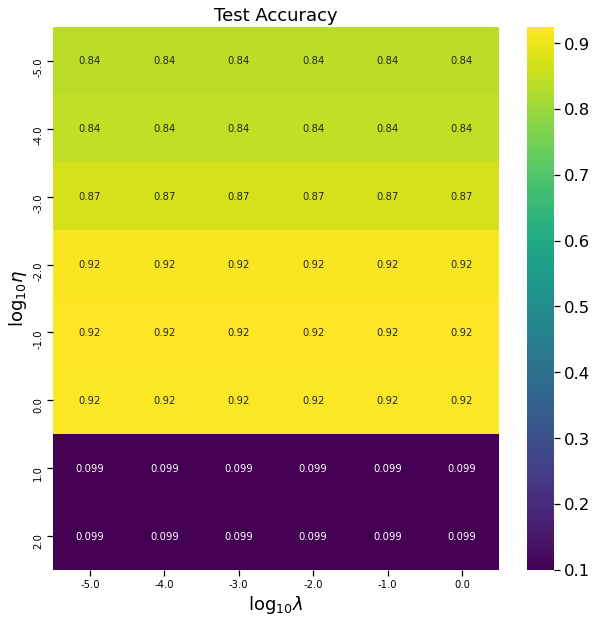

In [180]:
plot_accuracy(train, etas, lambdas)
plot_accuracy(test, etas, lambdas)

In [213]:
X, t = skl.datasets.load_digits(return_X_y=True)
n, p = X.shape
t_onehot = onehot(t, 10)

ffnn = FFNN(p, cost_function='cross-entropy')
ffnn.add_layer(50, activation_function='sigmoid')
ffnn.add_layer(10, activation_function='softmax')

k = 5
acc = np.zeros((k,k))
etas = np.logspace(-5,-1,k)
lambdas = np.logspace(-2,2,k)

train, test = neural.run_neural_network_kfold(X, t, ffnn, t_onehot=t_onehot, etas=etas, lambdas=lambdas, k=3, epochs=100, batches=14)

/home/olav/Documents/stud/FYS-STK4155/project2/source/FeedForwardNeuralNetwork.py:37: RuntimeWarning: invalid value encountered in true_divide
  return e/np.sum(e, axis=1, keepdims=True)
/home/olav/Documents/stud/FYS-STK4155/project2/source/FeedForwardNeuralNetwork.py:37: RuntimeWarning: invalid value encountered in true_divide
  return e/np.sum(e, axis=1, keepdims=True)
/home/olav/Documents/stud/FYS-STK4155/project2/source/FeedForwardNeuralNetwork.py:37: RuntimeWarning: invalid value encountered in true_divide
  return e/np.sum(e, axis=1, keepdims=True)
/home/olav/Documents/stud/FYS-STK4155/project2/source/FeedForwardNeuralNetwork.py:37: RuntimeWarning: invalid value encountered in true_divide
  return e/np.sum(e, axis=1, keepdims=True)
/home/olav/Documents/stud/FYS-STK4155/project2/source/FeedForwardNeuralNetwork.py:37: RuntimeWarning: invalid value encountered in true_divide
  return e/np.sum(e, axis=1, keepdims=True)
/home/olav/Documents/stud/FYS-STK4155/project2/source/FeedForward

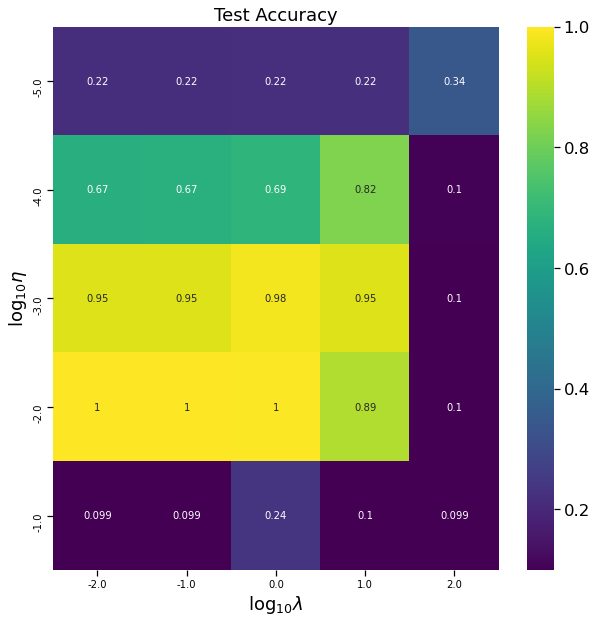

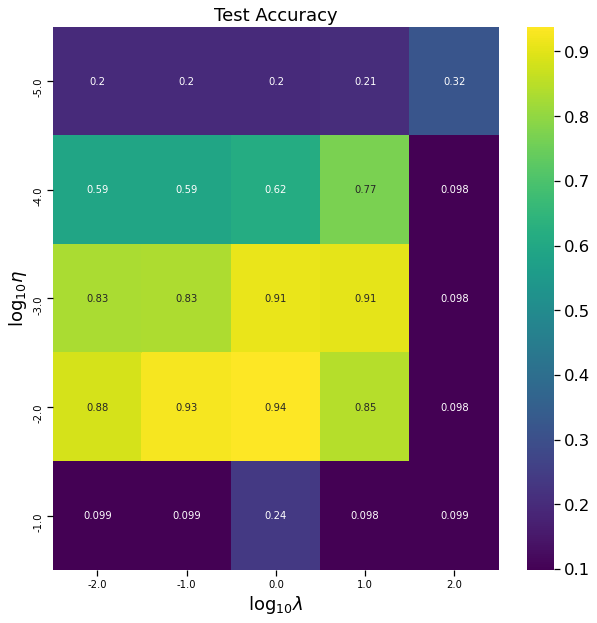

In [214]:
plot_accuracy(train, etas, lambdas)
plot_accuracy(test, etas, lambdas)